In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.15.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12127457511108732031
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12554865603830347407
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:

from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPool1D, MaxPool1D
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2
from statsmodels.tsa.stattools import adfuller

In [ ]:
data_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/'

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_instant_25.csv", index_col= 'Unnamed: 0')
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor1_data

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579
...,...,...,...
29795,22.855765,22.834129,-0.081526
29796,22.858710,22.840796,-0.034917
29797,22.862361,22.826919,0.009582
29798,22.865025,22.827342,0.021096


In [ ]:
len(sensor1_data)

29800

In [ ]:
sensor1_label = pd.read_csv(data_path+"Ground_truth_instant_25_sensor1.csv", names=['Class'])
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_label

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
29795,0.0
29796,0.0
29797,0.0
29798,0.0


In [ ]:
sensor1_label[0:9]

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_instant_25.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor2.csv",names=['Class'])
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_instant_25.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor3.csv", names=['Class'])
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_data['minus_speed'] = sensor1_data['InVehicle_Longitudinal_Speed']-sensor1_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor1_data['minus_acc'] = sensor1_data['InVehicle_Longitudinal_Accel']-sensor1_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor1_data['minus_Gps'] = sensor1_data['GPS_Speed']-sensor1_data['GPS_Speed'].shift(1)


In [ ]:
sensor1_data

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel,minus_speed,minus_acc,minus_Gps
0,11.375000,11.307097,-0.103000,NaN,NaN,NaN
1,11.366708,11.255964,-0.353946,-0.008292,-0.250946,-0.051133
2,11.362331,11.249115,-0.090962,-0.004377,0.262984,-0.006848
3,11.358665,11.263280,-0.043470,-0.003666,0.047492,0.014165
4,11.356745,11.270361,-0.037579,-0.001920,0.005891,0.007081
...,...,...,...,...,...,...
29795,22.855765,22.834129,-0.081526,0.000951,0.056680,-0.008746
29796,22.858710,22.840796,-0.034917,0.002945,0.046609,0.006667
29797,22.862361,22.826919,0.009582,0.003651,0.044499,-0.013876
29798,22.865025,22.827342,0.021096,0.002664,0.011513,0.000423


In [ ]:
sensor2_data['minus_speed'] = sensor2_data['InVehicle_Longitudinal_Speed']-sensor2_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor2_data['minus_acc'] = sensor2_data['InVehicle_Longitudinal_Accel']-sensor2_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor2_data['minus_Gps'] = sensor2_data['GPS_Speed']-sensor2_data['GPS_Speed'].shift(1)


In [ ]:
sensor3_data['minus_speed'] = sensor3_data['InVehicle_Longitudinal_Speed']-sensor3_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor3_data['minus_acc'] = sensor3_data['InVehicle_Longitudinal_Accel']-sensor3_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor3_data['minus_Gps'] = sensor3_data['GPS_Speed']-sensor3_data['GPS_Speed'].shift(1)


In [ ]:
sensor1_data.dropna(inplace= True)
sensor2_data.dropna(inplace= True)
sensor3_data.dropna(inplace= True)


In [ ]:
sensor1_data

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel,minus_speed,minus_acc,minus_Gps
1,11.366708,11.255964,-0.353946,-0.008292,-0.250946,-0.051133
2,11.362331,11.249115,-0.090962,-0.004377,0.262984,-0.006848
3,11.358665,11.263280,-0.043470,-0.003666,0.047492,0.014165
4,11.356745,11.270361,-0.037579,-0.001920,0.005891,0.007081
5,11.355560,11.255544,-0.039736,-0.001186,-0.002157,-0.014817
...,...,...,...,...,...,...
29795,22.855765,22.834129,-0.081526,0.000951,0.056680,-0.008746
29796,22.858710,22.840796,-0.034917,0.002945,0.046609,0.006667
29797,22.862361,22.826919,0.009582,0.003651,0.044499,-0.013876
29798,22.865025,22.827342,0.021096,0.002664,0.011513,0.000423


array([<Axes: >, <Axes: >], dtype=object)

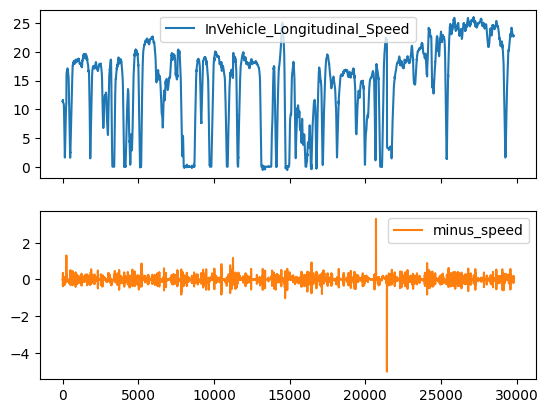

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

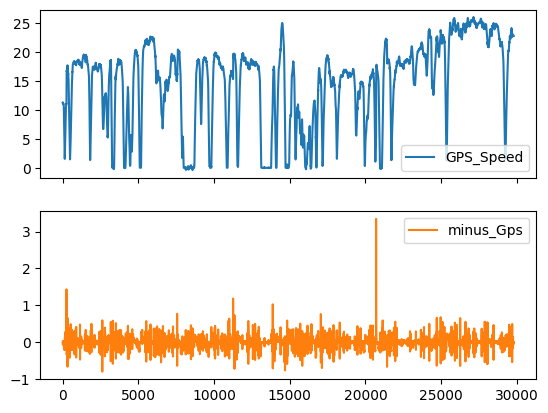

In [ ]:
sensor1_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

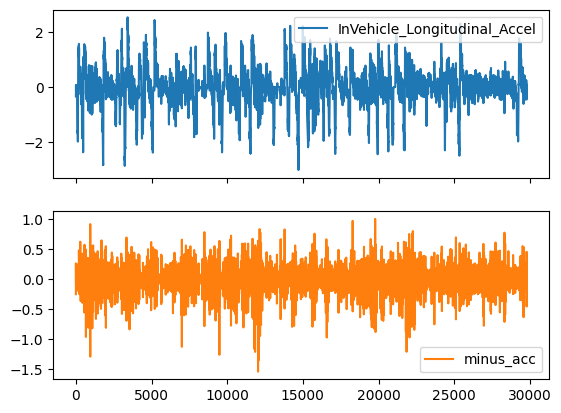

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor1_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor1_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor1_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 8.337580583419812e-30
stationary_gps :1.1152665494186632e-29
stationary_acc :0.0



In [ ]:
stationary_speed

(-17.030067261781806,
 8.337580583419812e-30,
 23,
 29775,
 {'1%': -3.430569642782574,
  '5%': -2.8616370761459278,
  '10%': -2.566821670674757},
 -75098.33663014034)

In [ ]:
stationary_gps

(-16.8527944017161,
 1.1152665494186632e-29,
 12,
 29786,
 {'1%': -3.4305695616612795,
  '5%': -2.8616370402938447,
  '10%': -2.566821651591555},
 -84402.96133725136)

In [ ]:
stationary_acc

(-26.505590350677483,
 0.0,
 49,
 29749,
 {'1%': -3.4305698347623115,
  '5%': -2.861637160992617,
  '10%': -2.566821715836611},
 -41514.28941097343)

array([<Axes: >, <Axes: >], dtype=object)

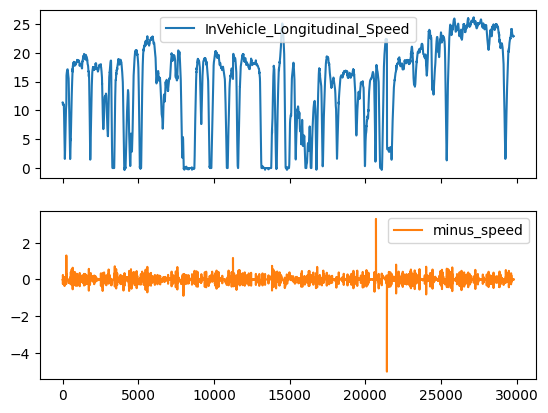

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

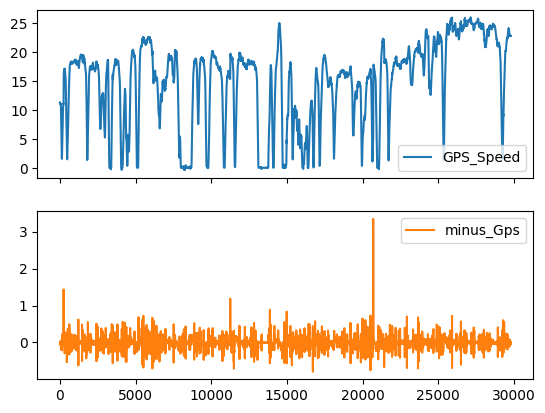

In [ ]:
sensor2_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

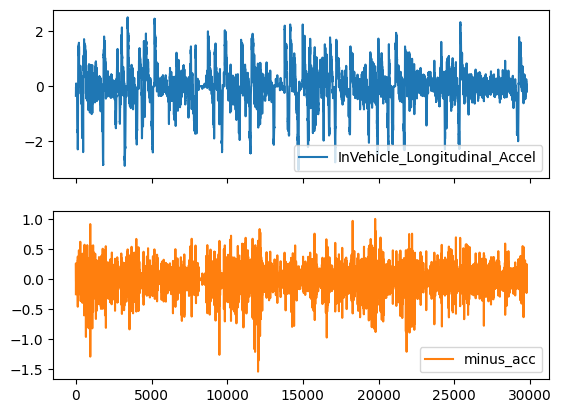

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor2_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor2_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor2_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 6.385273443912434e-30
stationary_gps :2.1030039281884131e-29
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

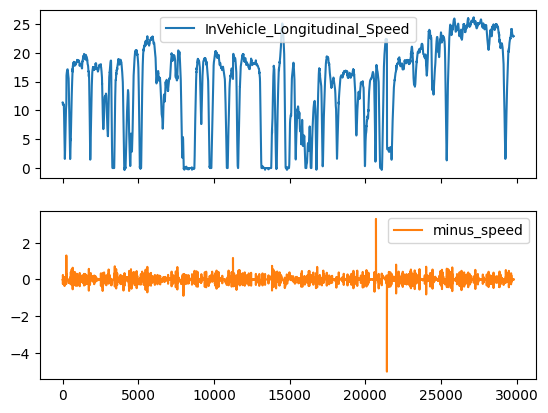

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

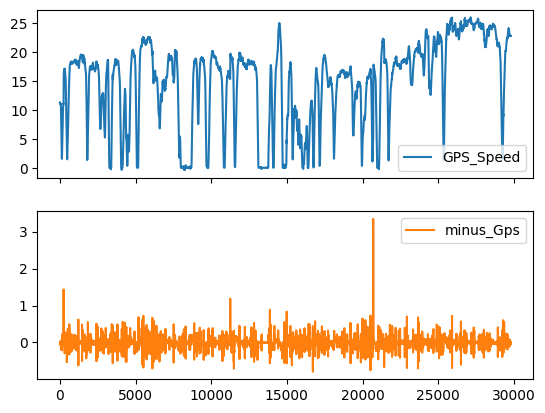

In [ ]:
sensor3_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

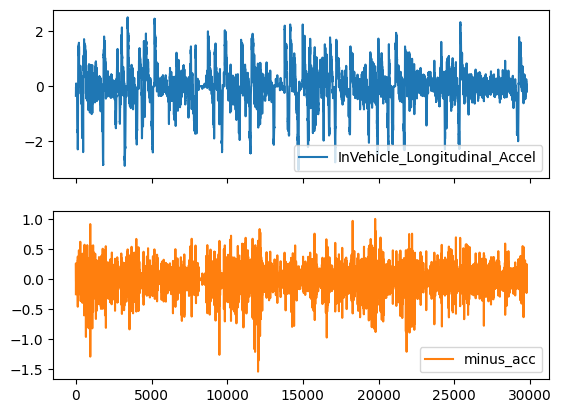

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor3_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor3_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor3_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 6.385273443912434e-30
stationary_gps :2.1030039281884131e-29
stationary_acc :0.0



In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal = scaler.transform(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal[:5]

array([[-0.08899598, -0.58055247, -2.07617264],
       [-0.04884877, -0.08151633,  2.17569258],
       [-0.04155831,  0.15527591,  0.39287459],
       [-0.0236437 ,  0.07545418,  0.04870355],
       [-0.01611489, -0.17131404, -0.01788491]])

In [ ]:
sensor1_data_normal

array([[-8.89959834e-02, -5.80552471e-01, -2.07617264e+00],
       [-4.88487729e-02, -8.15163269e-02,  2.17569258e+00],
       [-4.15583149e-02,  1.55275910e-01,  3.92874586e-01],
       ...,
       [ 3.34862338e-02, -1.60713653e-01,  3.68116623e-01],
       [ 2.33712016e-02,  4.26513184e-04,  9.52164606e-02],
       [ 2.36831970e-02, -3.99795471e-01,  6.94832069e-02]])

In [ ]:
len(sensor1_data_normal)

29799

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal = scaler.transform(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal[:5]

array([[-0.08911106, -0.58159003, -2.09183141],
       [-0.04891194, -0.08166201,  2.19210195],
       [-0.04161205,  0.15555342,  0.3958377 ],
       [-0.02367428,  0.07558903,  0.04907088],
       [-0.01613573, -0.17162021, -0.0180198 ]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal = scaler.transform(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal[:5]

array([[-0.08911106, -0.58159003, -2.09183141],
       [-0.04891194, -0.08166201,  2.19210195],
       [-0.04161205,  0.15555342,  0.3958377 ],
       [-0.02367428,  0.07558903,  0.04907088],
       [-0.01613573, -0.17162021, -0.0180198 ]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
#print(X_sensor1[0])
# print(X_sensor1[1])

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor1[0]

array([[-0.08899598, -0.58055247, -2.07617264],
       [-0.04884877, -0.08151633,  2.17569258],
       [-0.04155831,  0.15527591,  0.39287459],
       [-0.0236437 ,  0.07545418,  0.04870355],
       [-0.01611489, -0.17131404, -0.01788491],
       [-0.03645613, -0.03518268, -0.28650963],
       [-0.07413753, -0.10795266,  1.08869196],
       [-0.07739667, -0.16075636, -0.77547999],
       [-0.04911338, -0.06183797, -0.14989603],
       [-0.04441704, -0.01459347, -0.32641004]])

In [ ]:
X_sensor1

array([[[-8.89959834e-02, -5.80552471e-01, -2.07617264e+00],
        [-4.88487729e-02, -8.15163269e-02,  2.17569258e+00],
        [-4.15583149e-02,  1.55275910e-01,  3.92874586e-01],
        ...,
        [-7.73966651e-02, -1.60756362e-01, -7.75479989e-01],
        [-4.91133844e-02, -6.18379652e-02, -1.49896029e-01],
        [-4.44170425e-02, -1.45934673e-02, -3.26410040e-01]],

       [[-4.88487729e-02, -8.15163269e-02,  2.17569258e+00],
        [-4.15583149e-02,  1.55275910e-01,  3.92874586e-01],
        [-2.36437039e-02,  7.54541830e-02,  4.87035478e-02],
        ...,
        [-4.91133844e-02, -6.18379652e-02, -1.49896029e-01],
        [-4.44170425e-02, -1.45934673e-02, -3.26410040e-01],
        [-6.42391130e-02,  1.19918234e-01,  1.10313768e-01]],

       [[-4.15583149e-02,  1.55275910e-01,  3.92874586e-01],
        [-2.36437039e-02,  7.54541830e-02,  4.87035478e-02],
        [-1.61148904e-02, -1.71314037e-01, -1.78849052e-02],
        ...,
        [-4.44170425e-02, -1.45934673e-02,

In [ ]:
len(X_sensor1)

29789

In [ ]:
y_sensor1

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
y_sensor1[0]

array([0.])

In [ ]:
len(y_sensor1)

29789

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29789, 10, 3), (29789, 1))

In [ ]:
y_sensor1 = to_categorical(y_sensor1, num_classes= 2, dtype='float32')
y_sensor2 = to_categorical(y_sensor2, num_classes= 2, dtype='float32')
y_sensor3 = to_categorical(y_sensor3, num_classes= 2, dtype='float32')
y_sensor1.shape, y_sensor2.shape, y_sensor3.shape

((29789, 2), (29789, 2), (29789, 2))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensor1):
    # Split the data based on the indices
    X_train_sensor1, X_test_sensor1 = X_sensor1[train_index], X_sensor1[test_index]
    y_train_sensor1, y_test_sensor1 = y_sensor1[train_index], y_sensor1[test_index]

for train_index, test_index in tscv.split(X_sensor2):
    # Split the data based on the indices
    X_train_sensor2, X_test_sensor2 = X_sensor2[train_index], X_sensor2[test_index]
    y_train_sensor2, y_test_sensor2 = y_sensor2[train_index], y_sensor2[test_index]

for train_index, test_index in tscv.split(X_sensor3):
    # Split the data based on the indices
    X_train_sensor3, X_test_sensor3 = X_sensor3[train_index], X_sensor3[test_index]
    y_train_sensor3, y_test_sensor3 = y_sensor3[train_index], y_sensor3[test_index]

In [ ]:
X_train_sensor1.shape, X_test_sensor1.shape,y_train_sensor1.shape, y_test_sensor1.shape

((27081, 10, 3), (2708, 10, 3), (27081, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv1D(kernel_size=3, filters= 40, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add( Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    #model.add(Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    #model.add(Dropout(0.1))
    model.add(GlobalMaxPool1D())
    model.add(RepeatVector(X_train_sensor1.shape[1]))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(rate=0.2))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(Dropout(rate=0.2))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dropout(rate=0.2))
    model.add((Dense(32)))
    model.add((Dense(16)))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model


In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
# Function to calculate prediction time
def calculate_prediction_time(model, X_data):
    start_time = time.time()
    predictions = model.predict(X_data)
    end_time = time.time()
    prediction_time = end_time - start_time
    return prediction_time, predictions


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/Models/Models16-1-CNN-40-60-LSTM-256/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "CNN-LSTM-autoEncoder-Instant-25-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_CNN-LSTM-autoEncoder-Instant-25-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Instant-25_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 100)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensor1"
time_callback = TimeHistory()
model_sensor1 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor1")
history_sensor1 = model_sensor1.fit(X_train_sensor1, y_train_sensor1,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - 11s 14ms/step - loss: 0.2174 - accuracy: 0.9412 - val_loss: 0.0998 - val_accuracy: 0.9782 - epoch_time: 11.1035
Epoch 2/500
  1/191 [..............................] - ETA: 2s - loss: 0.1050 - accuracy: 0.9766

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 2s 9ms/step - loss: 0.0955 - accuracy: 0.9794 - val_loss: 0.0682 - val_accuracy: 0.9856 - epoch_time: 1.5076
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0749 - accuracy: 0.9835 - val_loss: 0.0509 - val_accuracy: 0.9893 - epoch_time: 1.2796
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0631 - accuracy: 0.9853 - val_loss: 0.0481 - val_accuracy: 0.9893 - epoch_time: 1.2605
Epoch 5/500
191/191 [==============================] - 2s 8ms/step - loss: 0.0559 - accuracy: 0.9867 - val_loss: 0.0443 - val_accuracy: 0.9886 - epoch_time: 1.3615
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0508 - accuracy: 0.9878 - val_loss: 0.0512 - val_accuracy: 0.9878 - epoch_time: 1.3425
Epoch 7/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0476 - accuracy: 0.9889 - val_loss: 0.0491 - val_accuracy: 0.9889 - epoch_time: 1.2553
Epoch 8/500
191/191 [=======

In [ ]:
print(model_sensor1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 40)            400       
                                                                 
 dropout (Dropout)           (None, 10, 40)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 60)            7260      
                                                                 
 dropout_1 (Dropout)         (None, 10, 60)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0         
 alMaxPooling1D)                                                 
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 60)            0         
 r)                                                     

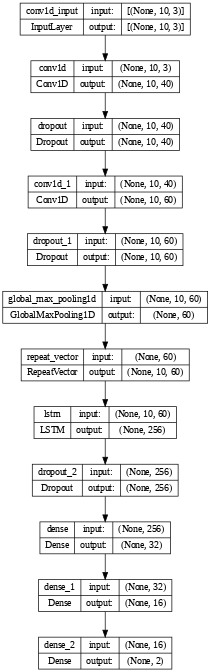

In [ ]:
plot_model(model= model_sensor1, show_shapes= True, dpi=50)

In [ ]:
sensor = "sensor2"
time_callback = TimeHistory()
model_sensor2 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor2")
history_sensor2 = model_sensor2.fit(X_train_sensor2, y_train_sensor2,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 5s 10ms/step - loss: 0.2188 - accuracy: 0.9395 - val_loss: 0.1212 - val_accuracy: 0.9738 - epoch_time: 5.2149
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1297 - accuracy: 0.9689 - val_loss: 0.0967 - val_accuracy: 0.9790 - epoch_time: 1.2436
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1121 - accuracy: 0.9723 - val_loss: 0.0940 - val_accuracy: 0.9801 - epoch_time: 1.2481
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1008 - accuracy: 0.9744 - val_loss: 0.0937 - val_accuracy: 0.9782 - epoch_time: 1.2419
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.0946 - accuracy: 0.9758 - val_loss: 0.0878 - val_accuracy: 0.9823 - epoch_time: 1.2709
Epoch 6/500
191/191 [==============================] - 3s 15ms/step - loss: 0.0909 - accuracy: 0.9763 - val_loss: 0.0858 - val_accuracy: 0.9815 - epoch_time: 2.7451
Epoch 7/500
19

In [ ]:
sensor = "sensor3"
time_callback = TimeHistory()
model_sensor3 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor3")
history_sensor3 = model_sensor3.fit(X_train_sensor3, y_train_sensor3,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 6s 13ms/step - loss: 0.4111 - accuracy: 0.8543 - val_loss: 0.4533 - val_accuracy: 0.8103 - epoch_time: 6.0121
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.3527 - accuracy: 0.8716 - val_loss: 0.4797 - val_accuracy: 0.8099 - epoch_time: 1.2645
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.3227 - accuracy: 0.8813 - val_loss: 0.4113 - val_accuracy: 0.8586 - epoch_time: 1.2456
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.3114 - accuracy: 0.8862 - val_loss: 0.4032 - val_accuracy: 0.8560 - epoch_time: 1.2458
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.2996 - accuracy: 0.8910 - val_loss: 0.3899 - val_accuracy: 0.8597 - epoch_time: 1.2357
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.2899 - accuracy: 0.8943 - val_loss: 0.3989 - val_accuracy: 0.8645 - epoch_time: 1.2616
Epoch 7/500
191

In [ ]:
#plot history of model_sensor1
history_sensor1 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor1.csv", index_col='epoch')
history_sensor1.reset_index(drop= True, inplace= True)
history_sensor1.head()
print('Average Exe_time for sensor1: {} sec.'.format(round(np.mean(history_sensor1['epoch_time'].values),3)))


Average Exe_time for sensor1: 1.478 sec.


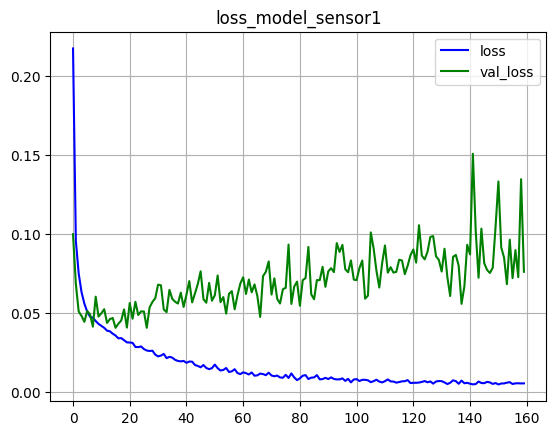

In [ ]:
plt.plot( history_sensor1['loss'], 'b',label = 'loss')
plt.plot( history_sensor1['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor1')
plt.show()

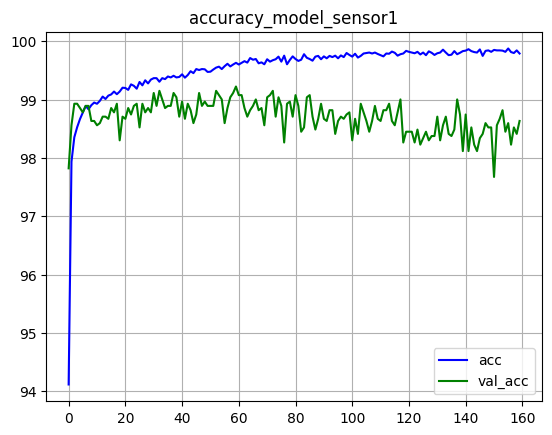

In [ ]:
plt.plot(history_sensor1['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor1['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor1')
plt.show()

In [ ]:
history_sensor2 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor2.csv", index_col='epoch')
history_sensor2.reset_index(drop= True, inplace= True)
history_sensor2.head()
print('Average Exe_time for sensor2: {} sec.'.format(round(np.mean(history_sensor2['epoch_time'].values),3)))


Average Exe_time for sensor2: 1.466 sec.


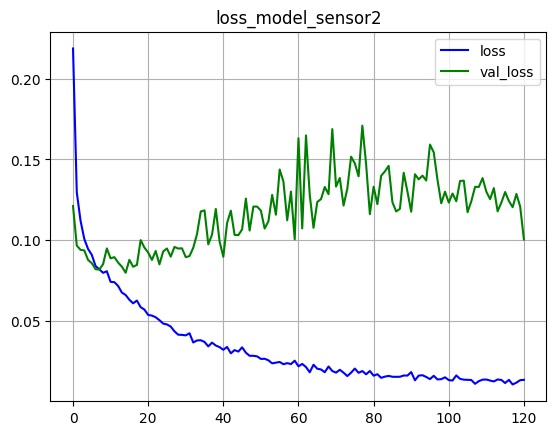

In [ ]:
plt.plot( history_sensor2['loss'], 'b',label = 'loss')
plt.plot( history_sensor2['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor2')
plt.show()

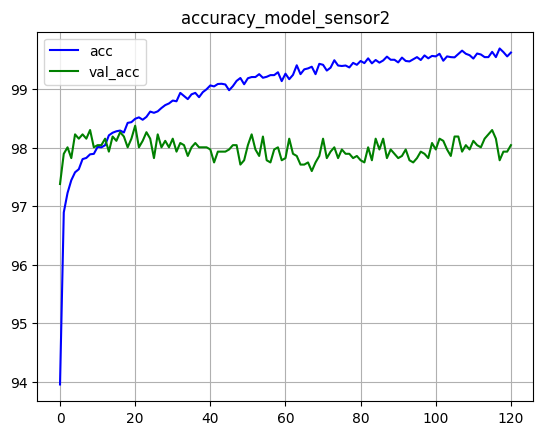

In [ ]:
plt.plot(history_sensor2['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor2['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor2')
plt.show()

In [ ]:
history_sensor3 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor3.csv", index_col='epoch')
history_sensor3.reset_index(drop= True, inplace= True)
history_sensor3.head()
print('Average Exe_time for sensor3: {} sec.'.format(round(np.mean(history_sensor3['epoch_time'].values),3)))


Average Exe_time for sensor3: 1.432 sec.


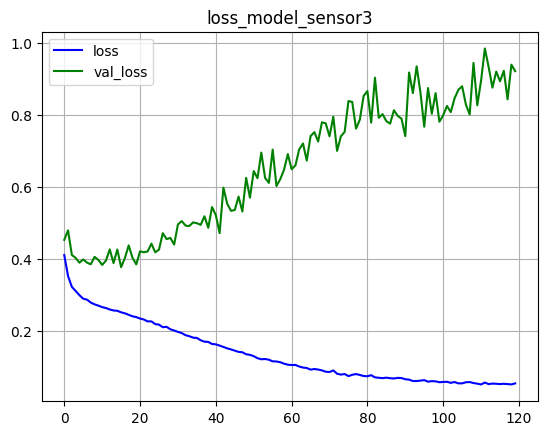

In [ ]:
plt.plot( history_sensor3['loss'], 'b',label = 'loss')
plt.plot( history_sensor3['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor3')
plt.show()

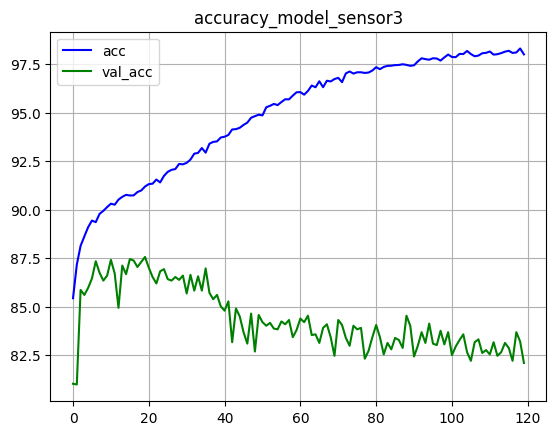

In [ ]:
plt.plot(history_sensor3['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor3['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor3')
plt.show()

In [ ]:
# Calculate prediction time for sensor1
prediction_time_sensor1, _ = calculate_prediction_time(model_sensor1, X_test_sensor1)
print(f'Prediction time for sensor1: {prediction_time_sensor1} seconds')

85/85 [==============================] - 1s 3ms/step
Prediction time for sensor1: 1.0368595123291016 seconds


In [ ]:
# Calculate prediction time for sensor2
prediction_time_sensor2, _ = calculate_prediction_time(model_sensor2, X_test_sensor2)
print(f'Prediction time for sensor2: {prediction_time_sensor2} seconds')

85/85 [==============================] - 1s 3ms/step
Prediction time for sensor2: 1.1763544082641602 seconds


In [ ]:
# Calculate prediction time for sensor3
prediction_time_sensor3, _ = calculate_prediction_time(model_sensor3, X_test_sensor3)
print(f'Prediction time for sensor3: {prediction_time_sensor3} seconds')

85/85 [==============================] - 1s 3ms/step
Prediction time for sensor3: 1.198838233947754 seconds


In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensor1.evaluate( X_test_sensor1, y_test_sensor1, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 3ms/step - loss: 0.0608 - accuracy: 0.9926
test accuracy :99.3% 
 test loss :0.0608


In [ ]:
#last model_sensor2 evaluation
test_loss, test_acc = model_sensor2.evaluate( X_test_sensor2, y_test_sensor2, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 4ms/step - loss: 0.1615 - accuracy: 0.9730
test accuracy :97.3% 
 test loss :0.162


In [ ]:
#last model_sensor3 evaluation
test_loss, test_acc = model_sensor3.evaluate( X_test_sensor3, y_test_sensor3, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 5ms/step - loss: 0.8416 - accuracy: 0.8497
test accuracy :85.0% 
 test loss :0.842


In [ ]:
y_pred_sensor1 = model_sensor1.predict( X_test_sensor1, verbose= 1)
y_pred_sensor2 = model_sensor2.predict( X_test_sensor2, verbose= 1)
y_pred_sensor3 = model_sensor3.predict( X_test_sensor3, verbose= 1)

85/85 [==============================] - 0s 3ms/step


In [ ]:
y_pred_sensor1

array([[9.9999869e-01, 1.3024789e-06],
       [9.9999952e-01, 4.7082182e-07],
       [9.9999905e-01, 9.0579351e-07],
       ...,
       [6.8552583e-07, 9.9999928e-01],
       [6.8495405e-07, 9.9999928e-01],
       [7.4934690e-07, 9.9999928e-01]], dtype=float32)

In [ ]:
y_pred_sensor1 = [np.argmax(i) for i in y_pred_sensor1]
y_pred_sensor2 = [np.argmax(i) for i in y_pred_sensor2]
y_pred_sensor3 = [np.argmax(i) for i in y_pred_sensor3]

In [ ]:
y_pred_sensor1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
y_pred_total = []
for i in range(len(y_pred_sensor1)):
  y_pred_total.append( y_pred_sensor1[i] or y_pred_sensor2[i] or y_pred_sensor3[i])

In [ ]:
assert(len(y_pred_total) == len(y_pred_sensor1))

In [ ]:
y_test_sensor1 = [np.argmax(i) for i in y_test_sensor1]
y_test_sensor2 = [np.argmax(i) for i in y_test_sensor2]
y_test_sensor3 = [np.argmax(i) for i in y_test_sensor3]

In [ ]:
y_test_sensor1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
y_test_total = []
for i in range(len(y_test_sensor1)):
  y_test_total.append(y_test_sensor1[i] or y_test_sensor2[i] or y_test_sensor3[i])

In [ ]:
y_test_total

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
print("Sensor 1 performanace:")
recall = recall_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor1, y_pred_sensor1, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor1, y_pred_sensor1)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 1 performanace:
recall score : 99.26%

precision score: 99.26%

F1 score: 99.26%

accuracy score: 99.26%



In [ ]:
print("Sensor 2 performanace:")
recall = recall_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor2, y_pred_sensor2, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor2, y_pred_sensor2)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 2 performanace:
recall score : 97.30%

precision score: 97.30%

F1 score: 97.30%

accuracy score: 97.30%



In [ ]:
print("Sensor 3 performanace:")
recall = recall_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor3, y_pred_sensor3, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor3, y_pred_sensor3)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 3 performanace:
recall score : 84.97%

precision score: 84.97%

F1 score: 84.97%

accuracy score: 84.97%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 87.15%

precision score: 87.15%

F1 score: 87.15%

accuracy score: 87.15%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 84.83%

precision score: 87.50%

F1 score: 85.83%

accuracy score: 87.15%



In [ ]:
conf = confusion_matrix(y_test_total, y_pred_total, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,767,248
0,100,1593
